Found 10000 files belonging to 5 classes.
Found 1500 files belonging to 5 classes.
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 145ms/step - accuracy: 0.5545 - loss: 1.1212 - val_accuracy: 0.6547 - val_loss: 0.9058
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 144ms/step - accuracy: 0.6724 - loss: 0.8938 - val_accuracy: 0.6767 - val_loss: 0.8669
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 146ms/step - accuracy: 0.7065 - loss: 0.7968 - val_accuracy: 0.6927 - val_loss: 0.8316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━

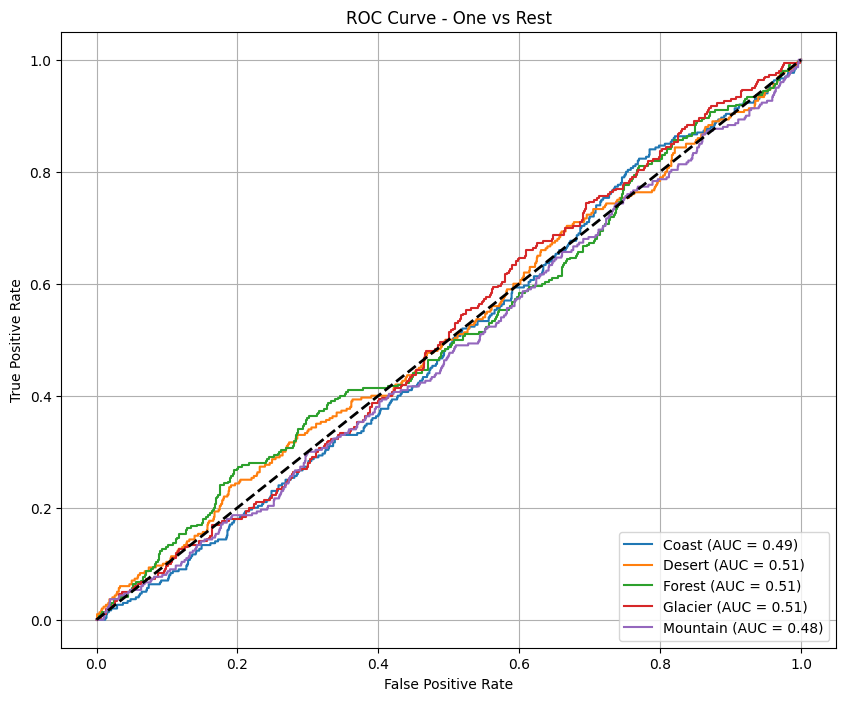

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc
from scipy.stats import ttest_ind, zscore
from sklearn.preprocessing import label_binarize

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#dataset path
base_path = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification'
train_path = os.path.join(base_path, 'Training Data')
val_path = os.path.join(base_path, 'Validation Data')

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 123

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path,
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Normalize
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


# Build model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

# Evaluate
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ROC Curve
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
y_score = []

for images, _ in val_ds:
    preds = model.predict(images)
    y_score.extend(preds)

y_score = np.array(y_score)

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - One vs Rest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [8]:
from scipy.stats import ttest_ind, f_oneway, zscore
import numpy as np

# Build dictionary to hold confidences for each true class
class_confidences = {cls: [] for cls in class_names}
for i, true_label in enumerate(y_true):
    class_confidences[class_names[true_label]].append(y_score[i][true_label])

# Sort classes by sample count (to ensure enough data)
sorted_classes = sorted(class_confidences.items(), key=lambda x: len(x[1]), reverse=True)
top_classes = [cls for cls, confs in sorted_classes[:3]]

print(f"\nUsing top classes for tests: {top_classes}")

# Extract confidence scores
conf1, conf2, conf3 = [class_confidences[cls] for cls in top_classes]

# --- Z-Test (combine first two) ---
combined = conf1 + conf2
z_scores = zscore(combined)
print(f"\nZ-Test Sample (first 5 Z-scores): {z_scores[:5]}")

# --- T-Test (between first two classes) ---
t_stat, p_val = ttest_ind(conf1, conf2, equal_var=False)
print(f"\nT-test between '{top_classes[0]}' and '{top_classes[1]}':")
print(f"T-statistic = {t_stat:.4f}, P-value = {p_val:.4f}")

# --- ANOVA Test (across all top 3 classes) ---
f_stat, p_anova = f_oneway(conf1, conf2, conf3)
print(f"\nANOVA test between {', '.join(top_classes)}:")
print(f"F-statistic = {f_stat:.4f}, P-value = {p_anova:.4f}")



Using top classes for tests: ['Coast', 'Desert', 'Forest']

Z-Test Sample (first 5 Z-scores): [-0.68977857  0.15781309 -0.5147521  -0.49255925 -0.76038104]

T-test between 'Coast' and 'Desert':
T-statistic = -0.3315, P-value = 0.7404

ANOVA test between Coast, Desert, Forest:
F-statistic = 0.1332, P-value = 0.8753


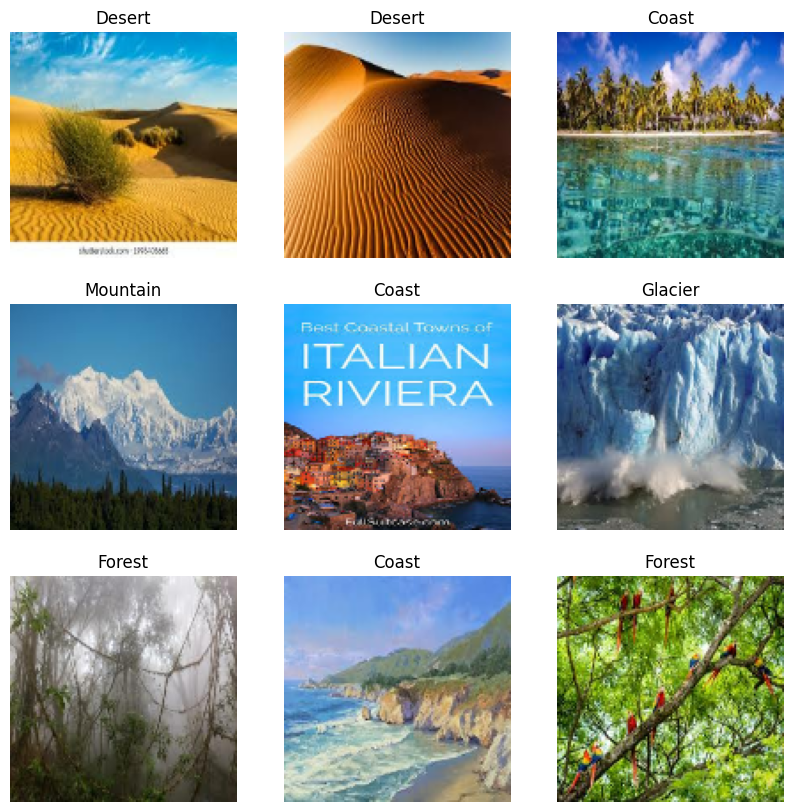

In [9]:
import matplotlib.pyplot as plt

# Display sample images
def show_sample_images(dataset, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take one batch
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i]])
            plt.axis("off")

show_sample_images(train_ds, class_names)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define CNN model for RGB images (3 channels)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generators
train_dir = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Training Data'
val_dir = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Testing Data'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Model definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)


Found 10000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 125s 388ms/step - accuracy: 0.5420 - loss: 1.1628 - val_accuracy: 0.6680 - val_loss: 0.8018
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 119s 378ms/step - accuracy: 0.6763 - loss: 0.8610 - val_accuracy: 0.7020 - val_loss: 0.7376
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 145s 387ms/step - accuracy: 0.7036 - loss: 0.7861 - val_accuracy: 0.7420 - val_loss: 0.6688
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 394ms/step - accuracy: 0.7360 - loss: 0.7245 - val_accuracy: 0.7000 - val_loss: 0.7298
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 125s 398ms/step - accuracy: 0.7411 - loss: 0.7073 - val_accuracy: 0.7680 - val_loss: 0.6357
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 399ms/step - accuracy: 0.7691 - loss: 0.6225 - val_accuracy: 0.7840 - val_loss: 0.6116
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 127s 405ms/step - accuracy: 0.7932 - loss: 0.5609 - val_accuracy: 0.7740 - val_loss: 0.6598
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 130s 412ms/step - accuracy: 0.8152 - loss: 0.50

In [24]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 127s 399ms/step - accuracy: 0.8710 - loss: 0.3530 - val_accuracy: 0.8080 - val_loss: 0.6495
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 132s 416ms/step - accuracy: 0.8962 - loss: 0.2886 - val_accuracy: 0.7940 - val_loss: 0.7699
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 129s 410ms/step - accuracy: 0.8996 - loss: 0.2740 - val_accuracy: 0.7840 - val_loss: 0.8276
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 414ms/step - accuracy: 0.9115 - loss: 0.2328 - val_accuracy: 0.7920 - val_loss: 0.7697
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 145s 423ms/step - accuracy: 0.9214 - loss: 0.2049 - val_accuracy: 0.7640 - val_loss: 0.9171
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 131s 418ms/step - accuracy: 0.9291 - loss: 0.1824 - val_accuracy: 0.8100 - val_loss: 0.7873
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 422ms/step - accuracy: 0.9456 - loss: 0.1560 - val_accuracy: 0.8120 - val_loss: 0.7622
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 136s 433ms/step - accuracy: 0.9470 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

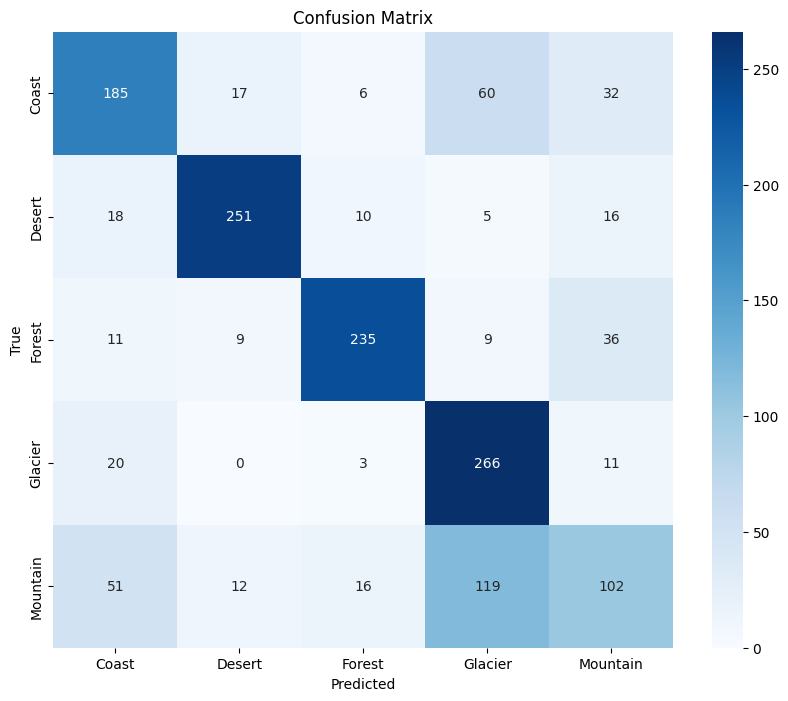

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
